# Ranking New York neighborhoods by Livability

[Report]()  
[Presentation]()

In [1]:
!wget "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City" -O wikipage.html
!conda install lxml xlrd --yes
import lxml
import pandas as pd
%matplotlib inline
########## You may need to restart the kernel for lxml to load correctly ##########

--2019-11-04 11:58:48--  https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City
Resolving en.wikipedia.org (en.wikipedia.org)... 208.80.154.224, 2620:0:861:ed1a::1
Connecting to en.wikipedia.org (en.wikipedia.org)|208.80.154.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160483 (157K) [text/html]
Saving to: ‘wikipage.html’

wikipage.html       100%[===================>] 156.72K  --.-KB/s    in 0.1s    

2019-11-04 11:58:48 (1.46 MB/s) - ‘wikipage.html’ saved [160483/160483]

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------

# Some stats on NYC neighborhoods 

Download and clean the data

In [5]:
df = pd.read_excel('https://www1.nyc.gov/assets/doh/downloads/excel/nta/nta-metadata.xlsx', sheet_name='NTA Data')
df['NTA_Name'] = df['NTA_Name'].apply(lambda x: x.split('-'))
df = df.explode('NTA_Name').reset_index().drop(axis=1,labels='index')
df.drop(axis=0, labels=[0,df.shape[0]-1], inplace=True)
df.tail()

,NTA_Name,NTA_Code,TotalPop,Female,PopU18,Pop18t24,Pop25t44,Pop45t64,Pop65pl,Hispanic,...,NitricOxide,NitrogenDioxide,Ozone,SulfurDioxide,Daycares,AlcoholRetailers,TobaccoRetailers,FelonyCrime,PropertyCrime,ViolentCrime
303,Rosebank,SI37,26596.0,49.8,23.4,10.2,29.4,24.9,12.0,30.4,...,17.2,17.9,30.8,0.4,34.0,29.0,19.9,19.7,9.4,6.3
304,New Dorp,SI45,20461.0,51.0,21.5,7.9,25.6,31.1,14.0,11.8,...,13.0,13.8,32.7,0.3,14.0,27.9,12.7,12.6,5.1,4.1
305,Midland Beach,SI45,20461.0,51.0,21.5,7.9,25.6,31.1,14.0,11.8,...,13.0,13.8,32.7,0.3,14.0,27.9,12.7,12.6,5.1,4.1
306,Arden Heights,SI48,25602.0,50.5,21.0,9.2,26.7,30.3,12.8,11.9,...,10.2,13.7,30.9,0.2,8.0,2.7,1.2,5.5,1.9,0.8
307,Great Kills,SI54,44078.0,50.9,20.5,8.3,26.7,29.8,14.8,9.8,...,10.6,13.5,32.3,0.3,17.0,18.4,7.7,6.6,3.0,1.2


We'll try to account for each of the following metrics while ranking New York neighborhoods according to livability score

In [12]:
scoring = {
    'Amenities':{
        'Groceries': 0.17,
        'Food & Drink': 0.17,
        'Shopping': 0.26,
        'Schools': 0.12,
        'Entertainment': 0.16,
        'Fitness Facilities': 0.06,
        'Transportation': 0.03,
        'Libraries': 0.03
    },
    'Cost of Living':{
        'Goods and Services': 0.3,
        'Groceries': 0.1,
        'Transportation':0.1,
        'Crowded Housing': 0.25,
        'Health Ins': 0.15,
        'Poverty': 0.1
    },
    'Crime':{
        'Violent Crime': 0.65,
        'Property Crime': 0.35
    },
    'Education':{
        'EduLessThanHS': 0.85,
        'Schools': 0.25
    },
    'Employment':{
        'Unemployment Rate': 0.1, 
    }
}

Make a Dataframe of coefficients to ease Livability indices calculation

In [13]:
sc = pd.DataFrame.from_dict(scoring)
sc.fillna(value=0.0, inplace=True)

## Populate and visualize the non-Foursquare Data

In [6]:
data = pd.DataFrame(columns=sc.index)
data_cols = ['Poverty','Violent Crime','Property Crime','EduLessThanHS','Crowded Housing','Health Ins', 'Unemployment Rate']
df_cols = ['Poverty','ViolentCrime','PropertyCrime','EduLessThanHS','CrowdedHousing','HealthIns', 'Unemployment']
data[data_cols] = df[df_cols]/100.0
data[['NTA_Name','NTA_Code']] = df[['NTA_Name','NTA_Code']]
data.head()

,Groceries,Food & Drink,Shopping,Schools,Entertainment,Fitness Facilities,Transportation,Libraries,Goods and Services,Crowded Housing,Health Ins,Poverty,Violent Crime,Property Crime,EduLessThanHS,Unemployment Rate,NTA_Name,NTA_Code
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032,0.930,0.100,0.017,0.074,0.022,0.054,Brooklyn Heights,BK09
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032,0.930,0.100,0.017,0.074,0.022,0.054,Cobble Hill,BK09
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.928,0.166,0.030,0.095,0.126,0.106,Sheepshead Bay,BK17
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.928,0.166,0.030,0.095,0.126,0.106,Gerritsen Beach,BK17
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.928,0.166,0.030,0.095,0.126,0.106,Manhattan Beach,BK17


## Populate and visualize the Foursquare Data

In [4]:
cols_from_foursquare = data.columns[1:10]
cols_from_foursquare

Index(['Groceries', 'Food & Drink', 'Shopping', 'Schools', 'Entertainment',
       'Fitness Facilities', 'Transportation', 'Libraries',
       'Goods and Services'],
      dtype='object')

In [9]:
CLIENT_ID = '3MKIHGV0WVV0W3KOSJL3VDRKOB5HVUB3TBVQBVXXGVYW2U0D' # your Foursquare ID
#CLIENT_ID = 'CK4U4NKQSFEVCERPK1UWRZOP3TG41AQTL35N4PIDK3U42MK2' # your Foursquare ID
#CLIENT_ID = 'WMPV0FAPIDDQUTAQNFMRGIP5YBLCX33RP5KUEGCFLSRYUSR5'
CLIENT_SECRET = 'XS5AOVAXCG4QQ3AWRCHU5VCVLSL2GJRCE24PQYPQGX0MFI30' # your Foursquare Secret
#CLIENT_SECRET = 'REM5J2HGCVRC3RM33ITWPI0I5E4KN31GWNDYXP55CQG4WULL' # your Foursquare Secret
#CLIENT_SECRET = 'RTDXMSLABUZX2ASHS31XBXA0DWVWNLAF3QWDVWVNURXIU1HC'
VERSION = '20191102'
ACCOUNT_TYPE = 'sandbox'
LIMIT = 20
radius = 1000

Setup a function to check Foursquare API status (Error Code handling)

In [10]:
def check_foursquare(results):
    if results['meta']['code'] == 400:
        if (results['meta']['errorType'] == 'failed_geocode'):
            return 10
    if results['meta']['code'] == 429:
        raise Exception ("Foursqure Quota exceeded ...")
    if results['meta']['code'] > 200:
        raise Exception ("Foursquare API: Error JSON\n {}".format(results))
    return 0

A function to populated requested Data columns from Foursquare

In [10]:
from IPython.display import clear_output, display
import statistics
import requests
import numpy as np
from time import sleep


# Define CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT
def populate_from_foursquare(data, searches, account_type, radius):
    """ Populate data columns from foursquare, 
        drops neighborhoods names which foursquare can't get a geocode for
        
        data: The dataframe to fill ('NTA_Name': neighborhoods column)
        searches: A subset of data columns to search foursquare for
        account_type: Foursquare account type
        radius: Search radius
    """
    search_template = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&query={}&limit={}'
    venue_details = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'
    all_queries = []
    
    for search_query in searches:
        location = []
        all_queries.append({'search':search_query})
        for i in data.index:
            clear_output(wait=True)
            sleep(0.5)
            place = data['NTA_Name'][i]
            url = search_template.format(CLIENT_ID, CLIENT_SECRET, place ,VERSION, search_query, LIMIT)
            results = requests.get(url).json()
            if (check_foursquare(results) == 10):
                display("{} didn't succeed".format(place))
                data.drop(labels=i,inplace=True)
                continue
            if search_query == searches[-1]:
                location.append(results['response']['geocode']['feature']['geometry']['center'])
            all_queries[-1]['place'] = place
            all_queries[-1]['venues'] = results['response']['venues']
            if (account_type != 'sandbox'):
                all_queries[-1]['venue_details'] = []
                likes = []
                for v in all_queries[-1]['venues']:
                    url = venue_details.format(v['id'],CLIENT_ID, CLIENT_SECRET, VERSION)
                    results = requests.get(url).json()
                    check_foursquare(results)
                    all_queries[-1]['venue_details'].append(results['response']['venue'])
                
                    likes.append(results['response']['venue']['likes']['count'])
                data[search_query].at[i] = statistics.mean(likes) if sum(likes) else np.nan
            else:
                data[search_query].at[i] = len(all_queries[-1]['venues'])
            display('{}: {}/{} {}'.format(search_query,i,data.shape[0], data[search_query][i]))
    data['Location'] = location
    return all_queries
    

These cells should execute only once! The queries results are all written to disk  
Have to do this with two Foursquare sandbox accounts!!

In [18]:
#queries02 = populate_from_foursquare(data, cols_from_foursquare[0:2], 'sandbox', 2500)

'Food & Drink: 307/245 20'

In [19]:
#import json
#with open('queries02.txt', 'w') as outfile:
#    json.dump(queries02, outfile)

In [21]:
#data.to_csv('data_queries02.csv')

In [22]:
#queries34 = populate_from_foursquare(data, cols_from_foursquare[3:4], 'sandbox', 2500)

'Schools: 307/245 20'

In [23]:
#with open('queries34.txt', 'w') as outfile:
#    json.dump(queries34, outfile)

In [25]:
#queries45 = populate_from_foursquare(data, cols_from_foursquare[4:5], 'sandbox', 2500)

'Entertainment: 307/245 20'

In [26]:
#with open('queries45.txt', 'w') as outfile:
    json.dump(queries45, outfile)

In [33]:
#queries57 = populate_from_foursquare(data, cols_from_foursquare[5:7], 'sandbox', 2500)

'Transportation: 307/245 20'

In [34]:
#with open('queries57.txt', 'w') as outfile:
#    json.dump(queries57, outfile)

In [35]:
#queries79 = populate_from_foursquare(data, cols_from_foursquare[7:8], 'sandbox', 2500)

'Libraries: 307/245 3'

In [40]:
#with open('queries78.txt', 'w') as outfile:
#    json.dump(queries79, outfile)

In [42]:
#queries89 = populate_from_foursquare(data, cols_from_foursquare[8:9], 'sandbox', 2500)

'Goods and Services: 307/245 20'

In [43]:
#with open('queries89.txt', 'w') as outfile:
#    json.dump(queries89, outfile)

In [45]:
#data[cols_from_foursquare] = data[cols_from_foursquare]/20.0

In [47]:
#data.to_csv('full_data.csv')

A box plot for Foursquare Data

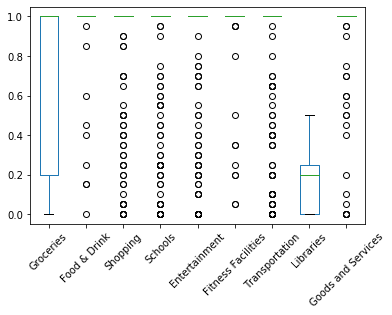

In [6]:
import pandas as pd
%matplotlib inline
data = pd.read_csv('full_data.csv')
data[cols_from_foursquare].plot(kind='box', rot=45)

And a box plot for Non-Foursquare data

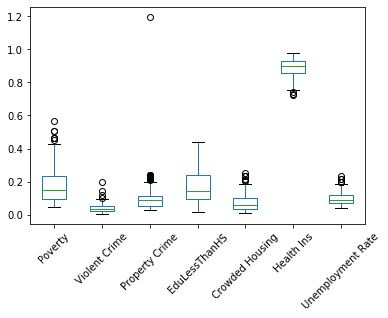

In [6]:
data_cols = ['Poverty','Violent Crime','Property Crime','EduLessThanHS','Crowded Housing','Health Ins', 'Unemployment Rate']
data[data_cols].plot(kind='box', rot=45)

## Livability Aspects calculation

Here we calculate each of the 5 Livability Aspects for each data row:

In [6]:
#sc['Amenities']
for i in range(len(sc.transpose())):
    tmp = pd.DataFrame(sc.transpose().iloc[[i]].values*data[data.columns[0:16]], columns=data.columns[0:16])
    data[sc.transpose().index[i]] = pd.DataFrame.sum(tmp,axis=1)

If the data is re-read from the CSV file, we need to fix the Location column so it has dictionaries

In [7]:
data = pd.read_csv('final_data.csv')
import ast
data.Location = data.Location.apply(ast.literal_eval)

Now lets import folium and create a function to draw on a map

In [8]:
import folium
# NYC location
latitude = 40.7128
longitude = -74.0060

# create map of NYC using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for loc, nei, in zip(data.Location, data.NTA_Name):
    label = '{}, NYC'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [loc['lat'], loc['lng']],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

## Neighborhood clustering 

In [10]:
from sklearn.cluster import KMeans

def cluster_data(data, targets, kclusters, cols_to_cluster):
    data_clustering = data[targets]

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_clustering[cols_to_cluster])

    # add clustering labels to dataframe
    data_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

    return data_clustering

Cluster in respect to all Livability Aspects

In [14]:
clustered_data = cluster_data(data, sc.columns, 7, sc.columns)

In [15]:
clustered_data.head()

,Cluster Labels,Amenities,Cost of Living,Crime,Education,Employment
0,6,0.8440,0.5825,0.03695,0.2687,0.0054
1,2,0.5325,0.4925,0.03695,0.0187,0.0054
2,0,0.9760,0.6693,0.05275,0.3571,0.0106
3,0,0.9760,0.6693,0.05275,0.3571,0.0106
4,0,0.9775,0.6693,0.05275,0.3571,0.0106


A function to plot neighborhoods with their clusters

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
# create map
def create_map(latitude, longitude, zoom, data, labels_col, kclusters):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=zoom)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for loc, nei, cluster in zip(data['Location'], data['NTA_Name'], data[labels_col]):
        label = '{}, NYC'.format(nei)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [loc['lat'], loc['lng']],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)  
       
    return map_clusters

In [18]:
data.to_csv('clustered.csv')

In [19]:
data['Cluster Labels'] = clustered_data['Cluster Labels']
map = create_map(latitude, longitude, 5, data, 'Cluster Labels', 7)
map

Discover how the clustering is distributed (Are there any outliers?)

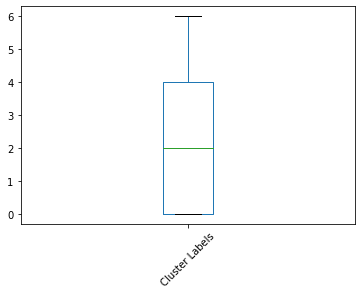

In [21]:
data['Cluster Labels'].plot(kind='box', rot=45)

We can even investigate the relationship Violent-Property Crimes

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


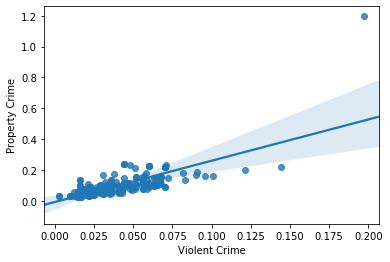

In [22]:
import seaborn as sbn
sbn.regplot(data['Violent Crime'], data['Property Crime'])